In [1]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

2025-10-17 16:59:15.126535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of replicas: 1


In [2]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

In [3]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

I0000 00:00:1760713157.120510   43634 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8973 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [4]:


COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

2025-10-17 16:59:17.268612: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:390] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-10-17 16:59:17.658336: W external/local_xla/xla/tsl/platform/cloud/google_auth_provider.cc:185] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".
2025-10-17 16:59:18.746898: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Normal images count in training set: 1349
Pneumonia images count in training set: 3883


2025-10-17 16:59:19.706681: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    if parts[-2] == "PNEUMONIA":
        return 1
    else:
        return 0


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [6]:
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

In [7]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

2025-10-17 16:59:32.519855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 346 of 10000
2025-10-17 16:59:52.947997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 990 of 10000
2025-10-17 17:00:12.914604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 3314 of 10000


Image shape:  (180, 180, 3)
Label:  1


2025-10-17 17:00:19.942313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


In [8]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [9]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [10]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


image_batch, label_batch = next(iter(train_ds))

2025-10-17 17:00:32.783184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 346 of 10000
2025-10-17 17:00:42.801496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 681 of 10000
2025-10-17 17:01:02.490996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 1092 of 10000
2025-10-17 17:01:12.647126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 1926 of 10000
2025-10-17 17:01:23.479528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-10-17 17:01:23.482614: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, th

In [22]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

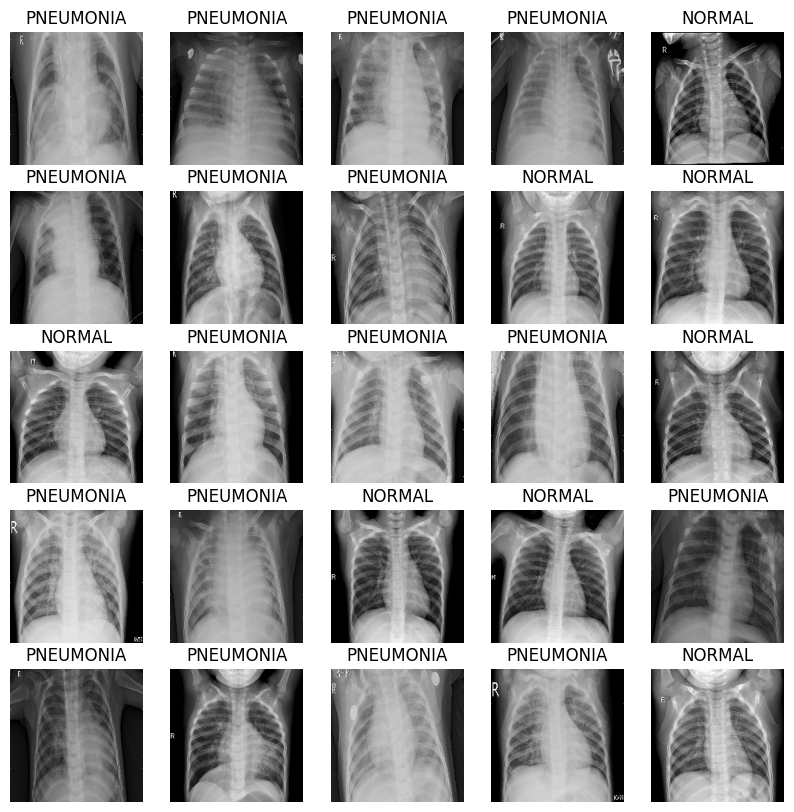

In [23]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [24]:
import os 
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from keras import layers

def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

In [25]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [26]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


In [27]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("xray_model.keras", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [28]:
initial_learning_rate = 0.015
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [29]:
with strategy.scope():
    model = build_model()

    METRICS = [
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
    165/Unknown 12s 17ms/step - binary_accuracy: 0.6277 - loss: 0.7420 - precision: 0.8347 - recall: 0.6145

2025-10-17 17:09:36.823931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885
2025-10-17 17:09:36.823956: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17258628407178045752


168/168 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - binary_accuracy: 0.6302 - loss: 0.7374 - precision: 0.8361 - recall: 0.6172 - val_binary_accuracy: 0.7393 - val_loss: 3.5485 - val_precision: 0.7393 - val_recall: 1.0000
Epoch 2/100
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.8630 - loss: 0.3341 - precision: 0.9492 - recall: 0.8605

2025-10-17 17:09:40.488093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - binary_accuracy: 0.8631 - loss: 0.3340 - precision: 0.9492 - recall: 0.8606 - val_binary_accuracy: 0.8081 - val_loss: 0.5544 - val_precision: 0.7952 - val_recall: 0.9974
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - binary_accuracy: 0.8992 - loss: 0.2635 - precision: 0.9588 - recall: 0.9022

2025-10-17 17:09:44.684325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14260170964996634783
2025-10-17 17:09:44.684338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885
2025-10-17 17:09:44.684345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17258628407178045752


168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - binary_accuracy: 0.8991 - loss: 0.2635 - precision: 0.9589 - recall: 0.9021 - val_binary_accuracy: 0.8333 - val_loss: 0.4495 - val_precision: 0.9417 - val_recall: 0.8257
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - binary_accuracy: 0.9159 - loss: 0.2293 - precision: 0.9704 - recall: 0.9141 - val_binary_accuracy: 0.7481 - val_loss: 0.6684 - val_precision: 0.7543 - val_recall: 0.9777
Epoch 5/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.9125 - loss: 0.1888 - precision: 0.9957 - recall: 0.8901

2025-10-17 17:09:49.511804: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - binary_accuracy: 0.9156 - loss: 0.2006 - precision: 0.9739 - recall: 0.9102 - val_binary_accuracy: 0.7393 - val_loss: 15.4604 - val_precision: 0.7393 - val_recall: 1.0000
Epoch 6/100
  6/168 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.8989 - loss: 0.2150 - precision: 0.9827 - recall: 0.8851

2025-10-17 17:09:53.950653: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.9210 - loss: 0.2127 - precision: 0.9744 - recall: 0.9172

2025-10-17 17:09:58.665772: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - binary_accuracy: 0.9210 - loss: 0.2126 - precision: 0.9744 - recall: 0.9172 - val_binary_accuracy: 0.9070 - val_loss: 0.3053 - val_precision: 0.9677 - val_recall: 0.9043
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.9311 - loss: 0.1688 - precision: 0.9801 - recall: 0.9256

2025-10-17 17:10:03.644450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - binary_accuracy: 0.9311 - loss: 0.1688 - precision: 0.9801 - recall: 0.9257 - val_binary_accuracy: 0.9254 - val_loss: 0.1902 - val_precision: 0.9648 - val_recall: 0.9332
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - binary_accuracy: 0.9397 - loss: 0.1594 - precision: 0.9824 - recall: 0.9352 - val_binary_accuracy: 0.8624 - val_loss: 0.5258 - val_precision: 0.8549 - val_recall: 0.9803
Epoch 9/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - binary_accuracy: 0.8885 - loss: 0.1674 - precision: 0.9957 - recall: 0.8593

2025-10-17 17:10:08.639614: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - binary_accuracy: 0.9258 - loss: 0.1862 - precision: 0.9783 - recall: 0.9200 - val_binary_accuracy: 0.7403 - val_loss: 1.0478 - val_precision: 0.7401 - val_recall: 1.0000
Epoch 10/100
  5/168 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - binary_accuracy: 0.9115 - loss: 0.1259 - precision: 0.9977 - recall: 0.8888

2025-10-17 17:10:13.511688: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.9433 - loss: 0.1441 - precision: 0.9839 - recall: 0.9388

2025-10-17 17:10:18.379789: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - binary_accuracy: 0.9433 - loss: 0.1442 - precision: 0.9838 - recall: 0.9388 - val_binary_accuracy: 0.9593 - val_loss: 0.1253 - val_precision: 0.9891 - val_recall: 0.9554
Epoch 11/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.9509 - loss: 0.1340 - precision: 0.9867 - recall: 0.9463

2025-10-17 17:10:23.483477: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - binary_accuracy: 0.9509 - loss: 0.1341 - precision: 0.9867 - recall: 0.9463 - val_binary_accuracy: 0.9632 - val_loss: 0.1117 - val_precision: 0.9879 - val_recall: 0.9620
Epoch 12/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9428 - loss: 0.1447 - precision: 0.9813 - recall: 0.9405 - val_binary_accuracy: 0.7578 - val_loss: 0.8970 - val_precision: 0.7532 - val_recall: 1.0000
Epoch 13/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.9462 - loss: 0.1240 - precision: 1.0000 - recall: 0.9303

2025-10-17 17:10:28.542702: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - binary_accuracy: 0.9496 - loss: 0.1238 - precision: 0.9846 - recall: 0.9466 - val_binary_accuracy: 0.9467 - val_loss: 0.1845 - val_precision: 0.9360 - val_recall: 0.9961
Epoch 14/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - binary_accuracy: 0.9500 - loss: 0.1380 - precision: 0.9871 - recall: 0.9447 - val_binary_accuracy: 0.7936 - val_loss: 0.6990 - val_precision: 0.7818 - val_recall: 1.0000
Epoch 15/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.9628 - loss: 0.1157 - precision: 0.9834 - recall: 0.9680

2025-10-17 17:10:38.253505: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.8968 - loss: 0.2653 - precision: 0.9644 - recall: 0.8929 - val_binary_accuracy: 0.9331 - val_loss: 0.1759 - val_precision: 0.9495 - val_recall: 0.9607
Epoch 16/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.9237 - loss: 0.1530 - precision: 0.9957 - recall: 0.9044

2025-10-17 17:10:43.042045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9064 - loss: 0.2103 - precision: 0.9694 - recall: 0.9016 - val_binary_accuracy: 0.9477 - val_loss: 0.1554 - val_precision: 0.9917 - val_recall: 0.9371
Epoch 17/100
  6/168 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - binary_accuracy: 0.9340 - loss: 0.1409 - precision: 0.9878 - recall: 0.9260

2025-10-17 17:10:47.801568: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.9399 - loss: 0.1509 - precision: 0.9795 - recall: 0.9383

2025-10-17 17:10:52.617826: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - binary_accuracy: 0.9399 - loss: 0.1509 - precision: 0.9795 - recall: 0.9383 - val_binary_accuracy: 0.9632 - val_loss: 0.0968 - val_precision: 0.9630 - val_recall: 0.9882
Epoch 18/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - binary_accuracy: 0.9370 - loss: 0.1570 - precision: 0.9804 - recall: 0.9333 - val_binary_accuracy: 0.8663 - val_loss: 0.4837 - val_precision: 0.8468 - val_recall: 1.0000
Epoch 19/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.9412 - loss: 0.0982 - precision: 0.9959 - recall: 0.9275

2025-10-17 17:10:57.587761: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9430 - loss: 0.1478 - precision: 0.9817 - recall: 0.9403 - val_binary_accuracy: 0.9186 - val_loss: 0.1905 - val_precision: 0.9829 - val_recall: 0.9056
Epoch 20/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.9217 - loss: 0.1926 - precision: 0.9825 - recall: 0.9145

2025-10-17 17:11:02.336634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9371 - loss: 0.1793 - precision: 0.9805 - recall: 0.9334 - val_binary_accuracy: 0.9467 - val_loss: 0.1189 - val_precision: 0.9903 - val_recall: 0.9371
Epoch 21/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - binary_accuracy: 0.9098 - loss: 0.1298 - precision: 1.0000 - recall: 0.8832

2025-10-17 17:11:07.122521: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.9438 - loss: 0.1455 - precision: 0.9856 - recall: 0.9377

2025-10-17 17:11:11.642163: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14260170964996634783
2025-10-17 17:11:11.642176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885
2025-10-17 17:11:11.642184: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17258628407178045752


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9438 - loss: 0.1454 - precision: 0.9856 - recall: 0.9377 - val_binary_accuracy: 0.9419 - val_loss: 0.1382 - val_precision: 0.9795 - val_recall: 0.9410
Epoch 22/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9543 - loss: 0.1135 - precision: 0.9851 - recall: 0.9525 - val_binary_accuracy: 0.9448 - val_loss: 0.1552 - val_precision: 0.9503 - val_recall: 0.9764
Epoch 23/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.9403 - loss: 0.1022 - precision: 0.9959 - recall: 0.9268

2025-10-17 17:11:16.664591: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9596 - loss: 0.1083 - precision: 0.9884 - recall: 0.9566 - val_binary_accuracy: 0.9641 - val_loss: 0.0995 - val_precision: 0.9932 - val_recall: 0.9581
Epoch 24/100
  6/168 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - binary_accuracy: 0.9201 - loss: 0.1318 - precision: 0.9910 - recall: 0.9051

2025-10-17 17:11:21.436317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.9633 - loss: 0.0969 - precision: 0.9899 - recall: 0.9603

2025-10-17 17:11:26.253965: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - binary_accuracy: 0.9634 - loss: 0.0969 - precision: 0.9899 - recall: 0.9603 - val_binary_accuracy: 0.9709 - val_loss: 0.0869 - val_precision: 0.9729 - val_recall: 0.9882
Epoch 25/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9200 - loss: 0.2150 - precision: 0.9710 - recall: 0.9189 - val_binary_accuracy: 0.9651 - val_loss: 0.1014 - val_precision: 0.9715 - val_recall: 0.9817
Epoch 26/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - binary_accuracy: 0.9204 - loss: 0.0986 - precision: 0.9958 - recall: 0.9006

2025-10-17 17:11:31.235912: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - binary_accuracy: 0.9509 - loss: 0.1137 - precision: 0.9859 - recall: 0.9472 - val_binary_accuracy: 0.9661 - val_loss: 0.0893 - val_precision: 0.9959 - val_recall: 0.9581
Epoch 27/100
  6/168 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - binary_accuracy: 0.9632 - loss: 0.0603 - precision: 1.0000 - recall: 0.9524

2025-10-17 17:11:36.136123: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.9694 - loss: 0.0908 - precision: 0.9908 - recall: 0.9676

2025-10-17 17:11:40.897919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - binary_accuracy: 0.9693 - loss: 0.0911 - precision: 0.9908 - recall: 0.9675 - val_binary_accuracy: 0.9787 - val_loss: 0.0681 - val_precision: 0.9856 - val_recall: 0.9856
Epoch 28/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - binary_accuracy: 0.9683 - loss: 0.0951 - precision: 0.9909 - recall: 0.9661 - val_binary_accuracy: 0.9738 - val_loss: 0.0793 - val_precision: 0.9804 - val_recall: 0.9843
Epoch 29/100
  6/168 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - binary_accuracy: 0.9364 - loss: 0.0719 - precision: 1.0000 - recall: 0.9181

2025-10-17 17:11:45.710911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9676 - loss: 0.0771 - precision: 0.9912 - recall: 0.9648 - val_binary_accuracy: 0.9622 - val_loss: 0.1268 - val_precision: 0.9738 - val_recall: 0.9751
Epoch 30/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.9363 - loss: 0.1260 - precision: 1.0000 - recall: 0.9173

2025-10-17 17:11:50.380477: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.9612 - loss: 0.0948 - precision: 0.9903 - recall: 0.9569

2025-10-17 17:11:54.726204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14260170964996634783
2025-10-17 17:11:54.726219: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885
2025-10-17 17:11:54.726230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17258628407178045752


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - binary_accuracy: 0.9612 - loss: 0.0948 - precision: 0.9903 - recall: 0.9569 - val_binary_accuracy: 0.9758 - val_loss: 0.0770 - val_precision: 0.9719 - val_recall: 0.9961
Epoch 31/100
  6/168 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - binary_accuracy: 0.9719 - loss: 0.0596 - precision: 0.9761 - recall: 0.9874

2025-10-17 17:11:54.971308: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.9743 - loss: 0.0711 - precision: 0.9888 - recall: 0.9764

2025-10-17 17:11:59.374552: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14260170964996634783
2025-10-17 17:11:59.374570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885
2025-10-17 17:11:59.374580: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17258628407178045752


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9743 - loss: 0.0712 - precision: 0.9888 - recall: 0.9763 - val_binary_accuracy: 0.6773 - val_loss: 1.2582 - val_precision: 1.0000 - val_recall: 0.5636
Epoch 32/100
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.9670 - loss: 0.0871 - precision: 0.9912 - recall: 0.9639

2025-10-17 17:12:04.243151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - binary_accuracy: 0.9670 - loss: 0.0870 - precision: 0.9912 - recall: 0.9640 - val_binary_accuracy: 0.9767 - val_loss: 0.0569 - val_precision: 0.9743 - val_recall: 0.9948
Epoch 33/100
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.9717 - loss: 0.0887 - precision: 0.9909 - recall: 0.9705

2025-10-17 17:12:09.091661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - binary_accuracy: 0.9716 - loss: 0.0888 - precision: 0.9909 - recall: 0.9704 - val_binary_accuracy: 0.9816 - val_loss: 0.0474 - val_precision: 0.9895 - val_recall: 0.9856
Epoch 34/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.9797 - loss: 0.0568 - precision: 0.9941 - recall: 0.9783

2025-10-17 17:12:13.611665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14260170964996634783
2025-10-17 17:12:13.611680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885
2025-10-17 17:12:13.611690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17258628407178045752


168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - binary_accuracy: 0.9797 - loss: 0.0570 - precision: 0.9941 - recall: 0.9783 - val_binary_accuracy: 0.9797 - val_loss: 0.0554 - val_precision: 0.9920 - val_recall: 0.9803
Epoch 35/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.9550 - loss: 0.1093 - precision: 0.9877 - recall: 0.9534

2025-10-17 17:12:13.894877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - binary_accuracy: 0.9711 - loss: 0.0740 - precision: 0.9891 - recall: 0.9715 - val_binary_accuracy: 0.9380 - val_loss: 0.2188 - val_precision: 0.9247 - val_recall: 0.9974
Epoch 36/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.9857 - loss: 0.0599 - precision: 0.9879 - recall: 0.9931

2025-10-17 17:12:18.521207: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - binary_accuracy: 0.9668 - loss: 0.0957 - precision: 0.9898 - recall: 0.9650 - val_binary_accuracy: 0.9767 - val_loss: 0.0659 - val_precision: 0.9792 - val_recall: 0.9895
Epoch 37/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - binary_accuracy: 0.9800 - loss: 0.0303 - precision: 1.0000 - recall: 0.9741

2025-10-17 17:12:23.146834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - binary_accuracy: 0.9771 - loss: 0.0593 - precision: 0.9928 - recall: 0.9760 - val_binary_accuracy: 0.9816 - val_loss: 0.0522 - val_precision: 0.9856 - val_recall: 0.9895
Epoch 38/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.9957 - loss: 0.0240 - precision: 1.0000 - recall: 0.9942

2025-10-17 17:12:27.766042: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - binary_accuracy: 0.9786 - loss: 0.0588 - precision: 0.9913 - recall: 0.9796 - val_binary_accuracy: 0.9864 - val_loss: 0.0476 - val_precision: 0.9934 - val_recall: 0.9882
Epoch 39/100
  6/168 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.9796 - loss: 0.0291 - precision: 1.0000 - recall: 0.9736

2025-10-17 17:12:32.386219: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9826 - loss: 0.0489 - precision: 0.9961 - recall: 0.9803 - val_binary_accuracy: 0.9612 - val_loss: 0.1159 - val_precision: 1.0000 - val_recall: 0.9476
Epoch 40/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - binary_accuracy: 0.9909 - loss: 0.0286 - precision: 1.0000 - recall: 0.9881

2025-10-17 17:12:37.022367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - binary_accuracy: 0.9857 - loss: 0.0480 - precision: 0.9943 - recall: 0.9863 - val_binary_accuracy: 0.9758 - val_loss: 0.1181 - val_precision: 0.9933 - val_recall: 0.9738
Epoch 41/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9776 - loss: 0.0604 - precision: 0.9929 - recall: 0.9767 - val_binary_accuracy: 0.9545 - val_loss: 0.1600 - val_precision: 1.0000 - val_recall: 0.9384
Epoch 42/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9684 - loss: 0.0764 - precision: 0.9908 - recall: 0.9661 - val_binary_accuracy: 0.9680 - val_loss: 0.0855 - val_precision: 0.9986 - val_recall: 0.9581
Epoch 43/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - binary_accuracy: 0.9584 - loss: 0.1784 - precision: 0.9833 - recall: 0.9623

2025-10-17 17:12:50.926175: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.9723 - loss: 0.0790 - precision: 0.9921 - recall: 0.9702

2025-10-17 17:12:55.590678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - binary_accuracy: 0.9723 - loss: 0.0789 - precision: 0.9921 - recall: 0.9702 - val_binary_accuracy: 0.9855 - val_loss: 0.0339 - val_precision: 0.9921 - val_recall: 0.9882
Epoch 44/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - binary_accuracy: 0.9825 - loss: 0.0475 - precision: 0.9958 - recall: 0.9805 - val_binary_accuracy: 0.9477 - val_loss: 0.1844 - val_precision: 0.9371 - val_recall: 0.9961
Epoch 45/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - binary_accuracy: 0.9254 - loss: 0.1412 - precision: 1.0000 - recall: 0.9038

2025-10-17 17:13:00.385626: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9755 - loss: 0.0731 - precision: 0.9936 - recall: 0.9732 - val_binary_accuracy: 0.9496 - val_loss: 0.2222 - val_precision: 0.9824 - val_recall: 0.9489
Epoch 46/100
  6/168 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - binary_accuracy: 0.9837 - loss: 0.0455 - precision: 1.0000 - recall: 0.9791

2025-10-17 17:13:05.090830: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - binary_accuracy: 0.9764 - loss: 0.0622 - precision: 0.9926 - recall: 0.9754 - val_binary_accuracy: 0.9845 - val_loss: 0.0398 - val_precision: 0.9960 - val_recall: 0.9830
Epoch 47/100
  6/168 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - binary_accuracy: 0.9959 - loss: 0.0392 - precision: 1.0000 - recall: 0.9945

2025-10-17 17:13:09.997514: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.9833 - loss: 0.0583 - precision: 0.9955 - recall: 0.9818

2025-10-17 17:13:15.053697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - binary_accuracy: 0.9833 - loss: 0.0583 - precision: 0.9955 - recall: 0.9818 - val_binary_accuracy: 0.9864 - val_loss: 0.0312 - val_precision: 0.9947 - val_recall: 0.9869
Epoch 48/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9741 - loss: 0.0777 - precision: 0.9914 - recall: 0.9733 - val_binary_accuracy: 0.9467 - val_loss: 0.1329 - val_precision: 0.9986 - val_recall: 0.9292
Epoch 49/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - binary_accuracy: 1.0000 - loss: 0.0289 - precision: 1.0000 - recall: 1.0000

2025-10-17 17:13:20.253895: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - binary_accuracy: 0.9747 - loss: 0.0745 - precision: 0.9925 - recall: 0.9731 - val_binary_accuracy: 0.9671 - val_loss: 0.1074 - val_precision: 0.9986 - val_recall: 0.9567
Epoch 50/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - binary_accuracy: 0.9448 - loss: 0.1191 - precision: 1.0000 - recall: 0.9290

2025-10-17 17:13:25.276196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.9700 - loss: 0.0775 - precision: 0.9918 - recall: 0.9674

2025-10-17 17:13:29.970598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14260170964996634783
2025-10-17 17:13:29.970619: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17258628407178045752


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - binary_accuracy: 0.9700 - loss: 0.0775 - precision: 0.9918 - recall: 0.9674 - val_binary_accuracy: 0.9826 - val_loss: 0.0355 - val_precision: 0.9806 - val_recall: 0.9961
Epoch 51/100
  6/168 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - binary_accuracy: 0.9903 - loss: 0.0222 - precision: 1.0000 - recall: 0.9874

2025-10-17 17:13:30.223615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - binary_accuracy: 0.9770 - loss: 0.0666 - precision: 0.9916 - recall: 0.9771 - val_binary_accuracy: 0.9593 - val_loss: 0.1141 - val_precision: 1.0000 - val_recall: 0.9450
Epoch 52/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.9823 - loss: 0.0571 - precision: 1.0000 - recall: 0.9771

2025-10-17 17:13:35.164541: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9867 - loss: 0.0466 - precision: 0.9951 - recall: 0.9868 - val_binary_accuracy: 0.9390 - val_loss: 0.1908 - val_precision: 0.9986 - val_recall: 0.9187
Epoch 53/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - binary_accuracy: 0.9679 - loss: 0.0864 - precision: 0.9926 - recall: 0.9637 - val_binary_accuracy: 0.9826 - val_loss: 0.0601 - val_precision: 0.9934 - val_recall: 0.9830
Epoch 54/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9790 - loss: 0.0700 - precision: 0.9933 - recall: 0.9783 - val_binary_accuracy: 0.9826 - val_loss: 0.0631 - val_precision: 0.9987 - val_recall: 0.9777
Epoch 55/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - binary_accuracy: 0.9709 - loss: 0.0572 - precision: 1.0000 - recall: 0.9623

2025-10-17 17:13:49.571963: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - binary_accuracy: 0.9550 - loss: 0.1377 - precision: 0.9851 - recall: 0.9534 - val_binary_accuracy: 0.9486 - val_loss: 0.1225 - val_precision: 1.0000 - val_recall: 0.9305
Epoch 56/100
  7/168 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - binary_accuracy: 0.9475 - loss: 0.1033 - precision: 1.0000 - recall: 0.9322

2025-10-17 17:13:54.439341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885
2025-10-17 17:13:54.439363: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17258628407178045752


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - binary_accuracy: 0.9688 - loss: 0.0795 - precision: 0.9923 - recall: 0.9654 - val_binary_accuracy: 0.9845 - val_loss: 0.0402 - val_precision: 0.9819 - val_recall: 0.9974
Epoch 57/100
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.9768 - loss: 0.0646 - precision: 0.9931 - recall: 0.9754

2025-10-17 17:14:03.783703: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - binary_accuracy: 0.9768 - loss: 0.0646 - precision: 0.9931 - recall: 0.9754 - val_binary_accuracy: 0.9816 - val_loss: 0.0424 - val_precision: 0.9934 - val_recall: 0.9817


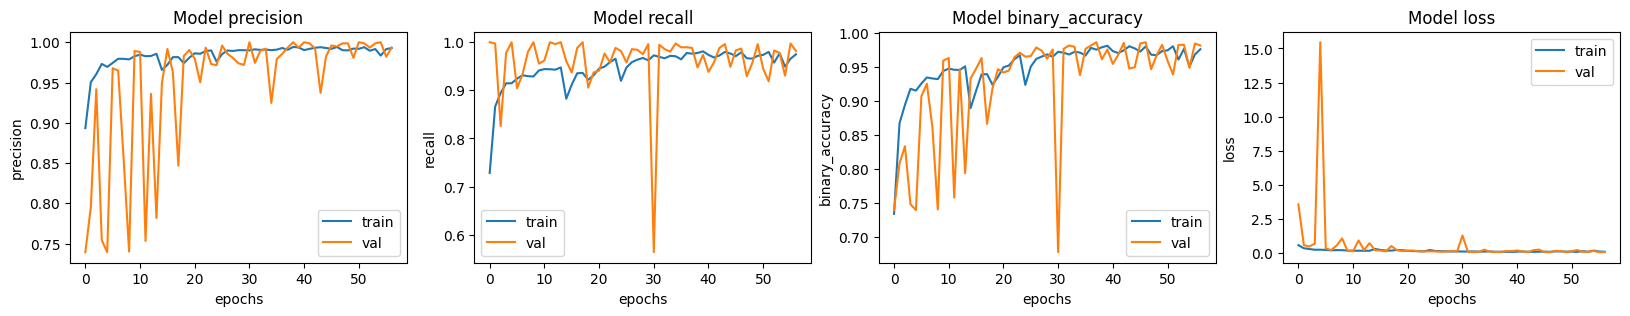

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [31]:
model.evaluate(test_ds, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - binary_accuracy: 0.5705 - loss: 1.8119 - precision: 0.3546 - recall: 0.6517


2025-10-17 17:14:10.761693: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17656791359862051885
2025-10-17 17:14:10.761715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17258628407178045752


{'binary_accuracy': 0.7692307829856873,
 'loss': 1.0453605651855469,
 'precision': 0.7320754528045654,
 'recall': 0.9948717951774597}

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
This image is 38.92 percent NORMAL
This image is 61.08 percent PNEUMONIA


/tmp/ipykernel_43634/2593322727.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("This image is %.2f percent %s" % ((100 * score), name))


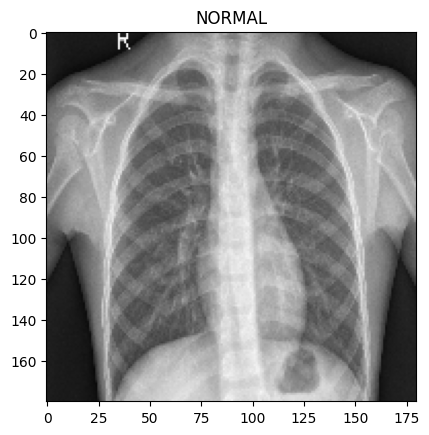

In [32]:
for image, label in test_ds.take(1):
    plt.imshow(image[0] / 255.0)
    plt.title(CLASS_NAMES[label[0].numpy()])

prediction = model.predict(test_ds.take(1))[0]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))